In [1]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

import pymorphy3
import razdel
from razdel import sentenize
from tqdm.notebook import tqdm
from alive_progress import alive_bar
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

morph = pymorphy3.MorphAnalyzer()

In [2]:
from matplotlib import rcParams
rcParams["figure.figsize"] = [10, 8]

In [3]:
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/dasha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df_cur = pd.read_excel("./data/currency.xlsx")
df_mon = pd.read_excel("./data/money.xlsx")
df_per = pd.read_excel("./data/percent.xlsx")
df_pr = pd.read_excel("./data/price.xlsx")
df_qu = pd.read_excel("./data/quantity.xlsx")

/home/dasha/.pyenv/versions/3.11.2/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/dasha/.pyenv/versions/3.11.2/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/dasha/.pyenv/versions/3.11.2/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/dasha/.pyenv/versions/3.11.2/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/dasha/.pyenv/versi

In [5]:
df_cur.shape, df_mon.shape, df_per.shape, df_pr.shape, df_qu.shape

((4369, 8), (12753, 8), (12072, 8), (1187, 8), (13935, 8))

money - 12753, 
percent - 12072, 
quantity - 13935,
price - 1187,
currency - 4369

In [6]:
df_mon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12753 entries, 0 to 12752
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   news_id           12753 non-null  int64         
 1   rel_id            12753 non-null  object        
 2   text              12753 non-null  object        
 3   title             12753 non-null  object        
 4   title_en          12753 non-null  object        
 5   url               12753 non-null  object        
 6   published_parsed  12753 non-null  datetime64[ns]
 7   raw_money         12753 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 797.2+ KB


Пока не свосем понятно, что содержат эти данные и как они между собой сочетаются.

В описании:
- QUANTITY – количества
- PERCENT – проценты
- MONEY – деньги
- PRICE – цена
- CURRENCY – валюта

Самые многочисленные данные с сущностями money, percent, quantity.

Кажется, что quantity должен дублировать остальные параметры.

money и price также могут содержать одинаковую информацию. Также сюда может и currency попадать.

Пробуем объединять попарно близкие по смыслу датасеты и смотреть, что общее, а что можно отбросить.

In [7]:
df_mon.head()

,news_id,rel_id,text,title,title_en,url,published_parsed,raw_money
0,26730,cb11ac18-558c-46a2-a60d-2f41ea962b7e,Стоимость российского сорта нефти Urals в Ротт...,Стоимость российского сорта нефти Urals в Ротт...,The price of Russian Urals oil in Rotterdam on...,https://lenta.ru/news/2020/04/03/ura/,2020-04-03 15:25:55,"1 304 рубль, 1 312 рубли, 14,43 доллар, 16,68 ..."
1,37599,cd9707e6-912f-4057-82c3-0d38fea38048,"Ташкент, , 11:29 — REGNUM Завод по производств...",Завод по производству аппаратов искусственной ...,The plant for the manufacture of artificial ve...,https://regnum.ru/news/society/2905966.html,2020-04-05 11:29:03,"$ 3 млн, $ 5−6 млн"
2,71467,ddbc5667-8f0a-4f3e-bb61-7b567451a2e0,"Эр-Рияд, , 05:24 — REGNUM Суверенный фонд Сауд...",Суверенный фонд Саудовской Аравии за последние...,The Saudi sovereign wealth fund has acquired t...,https://regnum.ru/news/economy/2910331.html,2020-04-09 05:24:05,около $ 1 млрд
3,96954,3b939ab3-9852-446a-bad3-492df7daf844,"НУР-СУЛТАН, 12 апреля. /ТАСС/. Производители к...","Производители космических аппаратов из России,...","Spacecraft manufacturers from Russia, France, ...",https://tass.ru/kosmos/8222861,2020-04-12 07:36:31,"39,65 млрд тенг, 91,6 млн доллары"
4,132107,44a45253-97c2-4df4-b881-9f4768f4c9b2,"ШАНХАЙ, 16 апреля. /ТАСС/. Автопроизводитель T...",Автопроизводитель Tesla открывает свой первый ...,Tesla is opening its first online store on Ali...,https://tass.ru/ekonomika/8256123,2020-04-16 07:40:42,"около $ 7, 2 млрд, порядок 50 млрд юани"


In [8]:
df_pr.head()

,news_id,rel_id,text,title,title_en,url,published_parsed,raw_price
0,6006315,b9f850a4-4d30-4115-894d-6858f7a8167b,Крупнейшие производители продовольствия продол...,Санкции против России не останавливают крупней...,Sanctions against Russia do not stop the world...,https://rossaprimavera.ru/news/d036d9dc,2022-04-22 13:19:12,"до $ 405, 00"
1,6007262,a7af90fe-6171-48c4-8eea-316e6e9c4cef,Макрон предупредил о проблемах зимой при отказ...,Макрон предупредил о проблемах зимой при отказ...,Macron warned of the problems of the EU's refu...,https://www.rbc.ru/politics/22/04/2022/6262968...,2022-04-22 15:01:47,до $ 300 – 500 за
2,6020351,2315dfa3-e2e2-4456-b18d-003be47a483c,The logo of Exxon Mobil Corporation is shown o...,Гана продала первую часть сырой нефти с новейш...,Ghana sold the first part of the crude oil fro...,https://www.reuters.com/business/energy/guyana...,2022-04-24 03:00:00,"$ 106, $ 106 million"
3,6020995,6d670b13-5527-4482-bd4d-c651d3431abb,"BRUSSELS, April 24 (Reuters) - The European Un...",В ходе встречи с премьер-министром Индии предс...,During his meeting with the Indian Prime Minis...,https://www.reuters.com/world/india/eu-chief-s...,2022-04-24 03:00:00,0.9264
4,6034845,3abb6ace-d2f0-4fc6-a8b0-4f4d0edd7ddd,Gold bars from the vault of a bank are seen in...,Объемы поставок швейцарского золота в США в ма...,Swiss gold shipments to the US in March 2022 r...,https://www.reuters.com/business/swiss-gold-ex...,2022-04-26 03:00:00,"1,900"


In [9]:
df_cur.head()

,news_id,rel_id,text,title,title_en,url,published_parsed,raw_currency
0,1466240,25b437c5-e431-4f8c-843f-fd92873f9642,Как в России перерабатывается вторсырье Во вто...,В правительстве РФ проработают вопрос о запрет...,The Russian government is working on a ban on ...,https://www.rbc.ru/business/08/10/2020/5f7db87...,2020-10-08 16:20:32,"евро, рубль"
1,1588697,dc1d8e96-f1d1-496e-a468-024193db8be2,"Согласно актуальным данным ФТС, Россия в авгус...","Россия в августе 2020 года экспортировала 20,6...",Russia exported 20.6 tonnes of gold in August ...,https://iz.ru/1074146/iurii-ivanov/zolotoe-vre...,2020-10-25 00:02:00,доллары
2,1877362,88869e30-b1f4-4031-a075-7736a287f524,Около двадцати танкеров с американской нефтью ...,Около двадцати танкеров с американской нефтью ...,About twenty American oil tankers were charter...,https://www.kommersant.ru/doc/4594677,2020-12-01 23:06:00,Рубль
3,3024352,0ea7e143-1ab8-4704-a572-3bc72d76ae10,https://ria.ru/20210429/partiya-1730531822.htm...,В октябре 2018 года Москва и Нью-Дели подписал...,"In October 2018, Moscow and New Delhi signed a...",https://ria.ru/20210429/partiya-1730531822.html,2021-04-29 17:00:39,рубли
4,3895907,1c8ec55a-3aba-4380-bfc7-9a2b21da860e,"Транзит удобрений ""Беларуськалия"" через Литву ...",Продукция белорусского производителя калийных ...,The products of the Belarusian potassium ferti...,https://www.interfax.ru/world/783902,2021-08-12 10:57:00,"доллары, евро"


Объеденим данные в один датасет.

Т.к. интересны все случаи совпадений и несовпадений в столбцах с количествами, берем объединение outer.

Делаем объединения итеративно, чтобы не множить одинаковые столбцы.

In [10]:
df1 = df_mon.merge(df_pr, on="rel_id", how="outer", suffixes=["", "_y"])

In [11]:
df1.head()

,news_id,rel_id,text,title,title_en,url,published_parsed,raw_money,news_id_y,text_y,title_y,title_en_y,url_y,published_parsed_y,raw_price
0,26730.0,cb11ac18-558c-46a2-a60d-2f41ea962b7e,Стоимость российского сорта нефти Urals в Ротт...,Стоимость российского сорта нефти Urals в Ротт...,The price of Russian Urals oil in Rotterdam on...,https://lenta.ru/news/2020/04/03/ura/,2020-04-03 15:25:55,"1 304 рубль, 1 312 рубли, 14,43 доллар, 16,68 ...",NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,37599.0,cd9707e6-912f-4057-82c3-0d38fea38048,"Ташкент, , 11:29 — REGNUM Завод по производств...",Завод по производству аппаратов искусственной ...,The plant for the manufacture of artificial ve...,https://regnum.ru/news/society/2905966.html,2020-04-05 11:29:03,"$ 3 млн, $ 5−6 млн",NaN,NaN,NaN,NaN,NaN,NaT,NaN
2,71467.0,ddbc5667-8f0a-4f3e-bb61-7b567451a2e0,"Эр-Рияд, , 05:24 — REGNUM Суверенный фонд Сауд...",Суверенный фонд Саудовской Аравии за последние...,The Saudi sovereign wealth fund has acquired t...,https://regnum.ru/news/economy/2910331.html,2020-04-09 05:24:05,около $ 1 млрд,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,96954.0,3b939ab3-9852-446a-bad3-492df7daf844,"НУР-СУЛТАН, 12 апреля. /ТАСС/. Производители к...","Производители космических аппаратов из России,...","Spacecraft manufacturers from Russia, France, ...",https://tass.ru/kosmos/8222861,2020-04-12 07:36:31,"39,65 млрд тенг, 91,6 млн доллары",NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,132107.0,44a45253-97c2-4df4-b881-9f4768f4c9b2,"ШАНХАЙ, 16 апреля. /ТАСС/. Автопроизводитель T...",Автопроизводитель Tesla открывает свой первый ...,Tesla is opening its first online store on Ali...,https://tass.ru/ekonomika/8256123,2020-04-16 07:40:42,"около $ 7, 2 млрд, порядок 50 млрд юани",NaN,NaN,NaN,NaN,NaN,NaT,NaN


In [12]:
df1.tail()

,news_id,rel_id,text,title,title_en,url,published_parsed,raw_money,news_id_y,text_y,title_y,title_en_y,url_y,published_parsed_y,raw_price
13258,NaN,15544b2f-d064-4bc8-b16a-31f5c4126d12,NaN,NaN,NaN,NaN,NaT,NaN,11139232.0,"Volkswagen 24 Hour Endurance Run: Virtus, Taig...",Hyundai Motor India готовится к запуску Hyunda...,Hyundai Motor India is all set to launch the H...,https://timesofindia.indiatimes.com/auto/cars/...,2024-03-10 08:04:16,"50, 000"
13259,NaN,c7db1451-fcda-4fa1-ba19-4653cd82b88a,NaN,NaN,NaN,NaN,NaT,NaN,11144475.0,"According to APK-Inform, during the past week,...",Цены на шрот подсолнечника на экспортном рынке...,Prices for sunflower seed meal on the Ukrainia...,https://www.apk-inform.com/en/news/1540273,2024-03-11 19:40:00,"170 USD / t, 5 USD / t"
13260,NaN,39aadb61-69e5-48a3-90e6-479a59afadd6,NaN,NaN,NaN,NaN,NaT,NaN,11153494.0,Samsung has launched its new range of AI Ecobu...,Компания Samsung представила в Индии новую лин...,Samsung has launched its new range of AI Ecobu...,https://timesofindia.indiatimes.com/technology...,2024-03-13 12:18:22,"Rs 67,"
13261,NaN,3a12ca84-d5e7-46ee-ac71-fb7570caff78,NaN,NaN,NaN,NaN,NaT,NaN,11157092.0,Smartphone market to see 3% uptick People chec...,"По прогнозам, рынок смартфонов в Таиланде выра...",Thailand's smartphone market is projected to g...,https://www.bangkokpost.com/business/general/2...,2024-03-14 02:32:00,$ 200
13262,NaN,6699d42b-b193-42b1-9016-ebaefe7c0a62,NaN,NaN,NaN,NaN,NaT,NaN,11157633.0,Maruti Suzuki India is offering tempting disco...,Maruti Suzuki India предлагает скидки на автом...,Maruti Suzuki India is offering discounts on i...,https://timesofindia.indiatimes.com/auto/cars/...,2024-03-14 08:32:51,"80, 000"


In [13]:
def process_df(df):
    with tqdm(total=df1.shape[0]) as pbar:
        for i, row in df1.iterrows():
            if row["text"] != row["text"]:
                df.at[i, "news_id"] = row["news_id_y"]
                df.at[i, "text"] = row["text_y"]
                df.at[i, "title"] = row["title_y"]
                df.at[i, "title_en"] = row["title_en_y"]
                df.at[i, "url"] = row["url_y"]
                df.at[i, "published_parsed"] = row["published_parsed_y"]
            pbar.update(1)
        df = df.drop(columns=["news_id_y", "text_y", "title_y", "title_en_y", "url_y", "published_parsed_y"])

    return df

In [14]:
df = process_df(df1)

  0%|          | 0/13263 [00:00<?, ?it/s]

In [15]:
df = df.drop_duplicates()

In [16]:
df.sample(5)

,news_id,rel_id,text,title,title_en,url,published_parsed,raw_money,raw_price
11508,10900071.0,cf6875c5-3599-47a1-ab3c-722c171667a0,"Stalled since June 2021, mechanical sweeping o...",Комитет по финансам и контрактам (F&CC) муници...,The Mohali municipal corporation’s finance and...,https://www.hindustantimes.com/cities/chandiga...,2024-01-24 03:05:37,"₹40 - crore, ₹52. 47 crore",NaN
2074,7055417.0,d5b5d280-5d81-42f9-9313-c7a9bd83172a,"CHILEAN president, Mr Sebastián Piñera, has of...",Чили заключила контракты на проектирование и м...,Chile has signed contracts for the design and ...,https://www.railjournal.com/infrastructure/chi...,2022-08-08 14:42:16,"$ US 2. 5bn, US 2. 5bn",NaN
3280,7546574.0,1b45c5ca-2b93-4b95-a7e5-b990a810f493,Объем импорта энергоресурсов из России в Китай...,Импорт энергоресурсов из РФ в КНР в марте-июле...,The import of energy resources from Russia to ...,https://expert.ru/2022/09/21/import-energoresu...,2022-09-21 11:37:32,"$ 117, 206 млрд, $ 146, 87 млрд, $ 165 - 170 м...",NaN
11947,10992344.0,1bef0d77-6a73-4dfd-b1e8-c4740b479bcd,HÀ NỘI The Vietnamese Trade Office in Australi...,Вьетнамское торговое представительство в Австр...,The Vietnamese Trade Representative Office in ...,https://vietnamnews.vn/economy/1650387/viet-na...,2024-02-09 05:16:00,"$ 5. 22 billion, $ 8. 53 billion, 13. 75 billion",NaN
5636,8930807.0,d8f6eb18-264a-4e2c-9cf7-9eb677cdd527,Russia’s Sakhalin 2 liquefied natural gas (LNG...,Российский проект по сжижению природного газа ...,Russia's Sakhalin-2 natural gas liquefaction p...,https://www.scmp.com/news/world/russia-central...,2023-01-25 13:58:36,"2 billion, 3. 8 billion, 4. 5 billion, 5. 7 bi...",US $ 38. 80


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13168 entries, 0 to 13262
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   news_id           13168 non-null  float64       
 1   rel_id            13168 non-null  object        
 2   text              13168 non-null  object        
 3   title             13168 non-null  object        
 4   title_en          13168 non-null  object        
 5   url               13168 non-null  object        
 6   published_parsed  13168 non-null  datetime64[ns]
 7   raw_money         12775 non-null  object        
 8   raw_price         1210 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 1.0+ MB


In [18]:
frames = [df_cur, df_per, df_qu]

In [19]:
for frame in frames:
    df1 = df.merge(frame, on="rel_id", how="outer", suffixes=["", "_y"])
    df = process_df(df1)
    df = df.drop_duplicates()

  0%|          | 0/14507 [00:00<?, ?it/s]

  0%|          | 0/19413 [00:00<?, ?it/s]

  0%|          | 0/23654 [00:00<?, ?it/s]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22839 entries, 0 to 23653
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   news_id           22839 non-null  float64       
 1   rel_id            22839 non-null  object        
 2   text              22839 non-null  object        
 3   title             22839 non-null  object        
 4   title_en          22839 non-null  object        
 5   url               22839 non-null  object        
 6   published_parsed  22839 non-null  datetime64[ns]
 7   raw_money         13002 non-null  object        
 8   raw_price         1313 non-null   object        
 9   raw_currency      4597 non-null   object        
 10  raw_percent       12325 non-null  object        
 11  raw_quantity      14088 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 2.3+ MB


В датасете собраны все возможные тексты, для которых есть сырые продукты (определенные NER) и страны (уже нормированы).

Убраем дубли из данных

Дубли по столбцам. Для начала сортируем данные по дате, чтобы по keep='last' оставить дубли с более поздним саммари, т.к. с развитем проекта экспертность аннотаторов повысилась и саммари стали более короткими, емкими, но при этом удовлетворяющими условиям заказчика.

In [21]:
df = df.sort_values("published_parsed")

In [22]:
df = df.drop_duplicates(subset="news_id", keep='last')
df = df.drop_duplicates(subset="rel_id", keep="last")
df = df.drop_duplicates(subset="text", keep="last")
df = df.drop_duplicates(subset="url", keep="last")
df.shape

(21279, 12)

In [23]:
df_all = df.dropna()
df_all.info()


<class 'pandas.core.frame.DataFrame'>
Index: 254 entries, 249 to 13547
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   news_id           254 non-null    float64       
 1   rel_id            254 non-null    object        
 2   text              254 non-null    object        
 3   title             254 non-null    object        
 4   title_en          254 non-null    object        
 5   url               254 non-null    object        
 6   published_parsed  254 non-null    datetime64[ns]
 7   raw_money         254 non-null    object        
 8   raw_price         254 non-null    object        
 9   raw_currency      254 non-null    object        
 10  raw_percent       254 non-null    object        
 11  raw_quantity      254 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 25.8+ KB


Всего 254 новости содержать все эти сущности. Посмотрим на эти новости и сущности.

In [24]:
# df_all.to_excel("digits.xlsx", index=False)

In [25]:
df_all.sample(10)

,news_id,rel_id,text,title,title_en,url,published_parsed,raw_money,raw_price,raw_currency,raw_percent,raw_quantity
11531,10779906.0,ab1aef77-b370-4e31-ad52-86e96bd85475,Export-bound cars await loading at Yantai Port...,Нежелание мировых судоходных компаний осуществ...,Global shipping companies' recent reluctance t...,http://www.ecns.cn/business/2023-12-20/detail-...,2023-12-20 12:42:18,"2, 000, 2, 500, 2, 600, 3, 000, 600","$, $ 4, 000",$,20 percent,10
1844,6956905.0,e208f84f-7259-452f-a485-435b551b1185,A man is seen next to a Panasonic logo at Pana...,"Японская компания Panasonic Holdings Corp, пос...","Japanese company Panasonic Holdings Corp, whic...",https://www.reuters.com/technology/panasonic-p...,2022-07-28 03:00:00,"$ 470. 77 million, 360 billion, 63.7 billion y...",135.3100,"$, yen",39 %,"four times, three"
10712,10625692.0,88c05a37-1f64-4390-972d-3cb34557f106,TOKYO (Reuters) -Japanese state-backed fund IN...,Японский государственный фонд INCJ продал всю ...,Japanese state fund INCJ sold all but a symbol...,https://www.usnews.com/news/technology/article...,2023-11-10 05:45:09,"1. 84 billion, 1. 8 Billion, 279 billion","2,143 yen, 2,224, 2,329.5 yen","$, yen","4.5%, 6.65%, 69 %, 8.01%","130 million, 75"
5815,8980193.0,fda335b1-e89c-4a85-bf31-1076ee012d1f,"NEW DELHI, India (AP) — India’s Adani Group, r...",Индийская Adani Group ответила на отчет америк...,Indian Adani Group responded to the report by ...,https://www.usnews.com/news/business/articles/...,2023-01-30 10:18:34,"$ 30 billion, $ 92. 7 billion, $ 9 billion, 12...","$ 35, 2,850 rupees, 3,276 rupees",$,"20 %, 2,000%, 3.2%, 3.3%, 5 %, 85 %","30, 400-page"
3945,7799035.0,06777cd1-adea-438b-adea-a00b71ea9121,"TOKYO, Oct 13 (Reuters) - Japan's Fast Retail...","Японская компания Fast Retailing Co, владелец ...","Japanese company Fast Retailing Co, owner of U...",https://www.reuters.com/business/retail-consum...,2022-10-13 03:00:00,"$ 2. 02 billion, 249 billion, 263 billion, 291...",146.8800,"dollar, yen","17 %, 21 %, 8.9%",12
4503,7922366.0,88870133-e821-4f75-971d-6c59819399f2,Summary Summary Companies Raises annual revenu...,Hyundai Motor Co повысила прогноз по прибыли н...,Hyundai Motor Co has raised its profit forecas...,https://www.reuters.com/business/autos-transpo...,2022-10-24 03:00:00,"$ 906 million, 1.36 trillion, 2.4 trillion, 36...","1,434.4400","$, won","1 %, 14 %, 17 %, 19-20%, 27 %, 3 %, 31 %, 3.3%...","3.89, 4.01 million, 4.01 mln, 4.32 mln"
4954,8362653.0,a7218130-6df6-4a03-94bf-74b05b1fa4c0,[1/5] Artisan miners work in an area where oth...,"Непрофессиональные перуанские шахтеры, обнаруж...",Non-professional Peruvian miners who discovere...,https://www.reuters.com/markets/commodities/pe...,2022-12-01 03:00:00,"2. 6 billion, 80","$ 20. 61, 3.8811 soles, soles",$,"18 %, 5 %, 60 %","1.8 million tonnes, 1,950 tonnes, two"
8521,10220671.0,3491f1c0-c358-4229-88ca-aa6064a4e43f,ALBAWABA – Economic growth in Saudi Arabia slo...,Экономический рост Саудовской Аравии замедлилс...,Saudi Arabia's economic growth slowed in the s...,https://www.albawaba.com/business/economic-gro...,2023-07-31 17:09:58,1 trillion,"$ 100, $ 84. 60",$,"11 percent, 1.2, 1.6 percent, 1.9, 3.8 percent...","10.5 million, a barrel"
10847,10649516.0,fa5b58ce-48a0-4d87-9bcd-08e8a58e4d4b,A worker is seen among newly manufactured cars...,Японский экспорт в октябре 2023 г. рос второй ...,Japanese exports in October 2023 grew for the ...,https://www.reuters.com/markets/asia/japans-ex...,2023-11-16 03:37:00,"$ 4. 38 billion, 662.5 billion, 735.7 billion",151.1900,"$, yen","0.5%, 0.9%, 1.2%, 12.2, 12.5%, 1.4%, 1.6%, 1.8...","straight quarters, two straight quarters"
7146,9822572.0,79796c2c-1b26-42cf-8361-4dccb453f9c6,NEW DELHI: Apple Inc’s sales in India hit a ne...,Продажи Apple Inc в Индии достигли нового макс...,Apple Inc's sales in India reached a new high ...,https://timesofindia.indiatimes.com/business/i...,2023-04-17 09:56:13,"$ 6 billion, 1.4 billion, 333.8 billion, 4. 1 ...",365,"$, rupees"

raw_currency содержит название валюты. Иногда в этот столбец попадает числовой показатель, но это случается редко, сами данные малочислены - всего 4369 из более чем 30 тысяч новостей.

Также, вероятно, можно убрать столбец raw_price как малочисленный (1187), но в некоторых саммари фигурируют данные из этого столбца, пока оставим и посмотрим.

In [26]:
df = df.drop('raw_currency', axis=1)

Определяем язык текста, чтобы оставить саммари только на нужном языке, также лемматизируем тексты и саммари. Из числовых столбцов оставим только число, без текста.

In [27]:
def get_numbers(text):
    text = str(text)
    numbers = []
    for word in text.split():
        if word.isdigit():
            numbers.append(int(word))
    return set(numbers)

In [28]:
def get_features(df):
    with tqdm(total=df.shape[0]) as pbar:
        for i, row in df.iterrows():
            if re.findall("[А-Яа-яёЁ]+", row['text']):
                df.at[i, "summary"] = row["title"]
                df.at[i, 'lang'] = 'ru'
                text_words = [word.text for word in razdel.tokenize(row["text"].lower())]
                summary_words = [word.text for word in razdel.tokenize(row["title"].lower())]
                text_lemmas = [morph.parse(word)[0].normal_form for word in text_words]
                summary_lemmas = [morph.parse(word)[0].normal_form for word in summary_words]
                df.at[i, "text_words"] = text_words
                df.at[i, "summary_words"] = summary_words
                df.at[i, "text_lemmas"] = text_lemmas
                df.at[i, "summary_lemmas"] = summary_lemmas    
            else:
                df.at[i, "summary"] = row["title_en"]
                df.at[i, "lang"] = "en"
                text_words = word_tokenize(row["text"].lower())
                summary_words = word_tokenize(row["title_en"].lower())
                text_lemmas = [lemmatizer.lemmatize(token) for token in text_words]
                summary_lemmas = [lemmatizer.lemmatize(token) for token in summary_words]
                df.at[i, "text_words"] = text_words
                df.at[i, "summary_words"] = summary_words
                df.at[i, "text_lemmas"] = text_lemmas
                df.at[i, "summary_lemmas"] = summary_lemmas            
            pbar.update(1)
    return df

In [29]:
df["summary"] = "-"
df["lang"] = "-"
df["text_words"] = "-"
df["summary_words"] = "-"
df["text_lemmas"] = "-"
df["summary_lemmas"] = "-"

In [30]:
df = get_features(df)

  0%|          | 0/21279 [00:00<?, ?it/s]

In [31]:
df["text_len"] = df["text_words"].apply(len)
df["summary_len"] = df["summary_words"].apply(len)
df["text_unique_len"] = df["text_words"].apply((lambda x: len(set(x))))
df["summary_unique_len"] = df["summary_words"].apply(lambda x: len(set(x)))
df["money"] = df["raw_money"].apply(get_numbers)
df["price"] = df["raw_price"].apply(get_numbers)
df["percent"] = df["raw_percent"].apply(get_numbers)
df["quantity"] = df["raw_quantity"].apply(get_numbers)
df["len_money"] = df["money"].apply(len)
df["len_price"] = df["price"].apply(len)
df["len_percent"] = df["percent"].apply(len)
df["len_quantity"] = df["quantity"].apply(len)

In [32]:
df.sample(10)

,news_id,rel_id,text,title,title_en,url,published_parsed,raw_money,raw_price,raw_percent,...,text_unique_len,summary_unique_len,money,price,percent,quantity,len_money,len_price,len_percent,len_quantity
5610,8863521.0,773b72f6-b4da-4c71-9427-67f3da6ea406,"""Тракторные заводы"" совместно с ITL начнут вып...","Концерн ""Тракторные заводы"" в марте 2023 года ...",Tractor Factories in March 2023 in partnership...,https://milknews.ru/index/traktory-apk-chuvash...,2023-01-19 11:34:00,"свыше 1, 7 млрд рубли",NaN,NaN,...,184,25,{7},{},{},"{16, 1}",1,0,0,2
12972,11051864.0,9760beb1-edd1-40ea-b073-c3b09d9d5de1,FT сообщила о планах Danone продать российский...,"Французская Danone, российские активы которой ...","French Danone, whose Russian assets have been ...",https://www.interfax.ru/business/947073,2024-02-21 08:55:00,"$ 191, 5 млн, 109,9 млрд рубли, 112,7 млрд руб...",NaN,56-процентная,...,300,23,"{700, 500, 5}",{},{},"{600, 100}",3,0,0,2
13935,10788942.0,e6faada9-be3d-4c1e-803e-b07e364c6f31,SA hosts dozens of highly successful conferenc...,Южная Африка ежегодно проводит десятки успешны...,SA hosts dozens of highly successful conferenc...,https://www.businesslive.co.za/economy/2023-12...,2023-12-22 10:00:23,NaN,",400, R559","23 %, 29 %, 48 %",...,609,111,{},{},"{48, 29, 23}",{860},0,0,3,1
10745,10634620.0,05e8a0bf-e15a-40bb-af1f-c83e68e619a6,HÀ NỘI — The UK-Việt Nam Free Trade Agreement ...,"Вьетнам экспортировал почти 1,2 миллиона тонн ...",Vietnam exported nearly 1.2 million tons of co...,https://vietnamnews.vn/economy/1636457/ukvfta-...,2023-11-13 04:37:45,"$ 3 billion, 32.3, 4 billion","2, 802","13.7 per cent, 21.21 per cent, 35.24 per cent,...",...,194,87,"{3, 4}",{802},{},{60},2,1,0,1
23460,11037101.0,4c1b5ffc-2e11-4522-b672-b42cb85db29c,Yomiuri Shimbun file photo Tokyo Stock Exchang...,В конце февраля 2024 года средний фондовый инд...,The benchmark Nikkei 225 stock average may hit...,https://japannews.yomiuri.co.jp/business/marke...,2024-02-18 03:00:00,NaN,NaN,NaN,...,184,45,{},{},{},{},0,0,0,0
3411,7550141.0,d7b07c4d-84c6-47da-bb00-69ab10a16dea,"Таллин, , 15:52 — REGNUM Эстония приняла принц...",Эстония приняла решение о закупке средств ПВО ...,Estonia has decided to purchase short-range ai...,https://regnum.ru/news/3703014.html,2022-09-21 15:52:13,"более 1, 2 млрд евро",NaN,"2,7%",...,283,27,{2},{},{},{},1,0,0,0
4828,8289030.0,3495ac30-8954-4a61-a360-c95545dbbd8a,Экспорт фосфатов и их производных из Марокко в...,Стоимость экспорта фосфатов и их производных и...,The value of phosphates and their derivatives ...,https://rossaprimavera.ru/news/e7161083,2022-11-24 23:10:25,"$ 5, 29 млрд, $ 8, 63 млрд, $ 8, 6 млрд, 56 мл...",$ 270,"10,5%, 34 %, 43,7%, 63 %, 72 %, 75 %",...,162,30,"{56, 29, 6, 63}",{270},"{72, 34, 75, 63}",{},4,1,4,0
3739,7687288.0,10912501-5e67-431b-b909-addea72b8a2e,Объединенные Арабские Эмираты и Султанат Оман ...,Объединенные Арабские Эмираты и Султанат Оман ...,The United Arab Emirates and the Sultanate of ...,https://are.minpromtorg.gov.ru/news/?alias=oae...,2022-10-03 03:00:00,"3 млрд долл., более 11 млрд дирхамы",NaN,NaN,...,179,33,"{11, 3}",{},{},{},2,0,0,0
6842,9624262.0,b9ecdce1-eb40-44db-8a30-f5d88f900872,Словакия ожидает получить от США грант на поку...,Словакия рассчитывает получить от США грант на...,Slovakia expects to receive a grant from the U...,https://rossaprimavera.ru/news/44dbfa26,2023-03-29 22:30:45,$ 200 млн,NaN,NaN,...,111,32,{200},{},{},{},1,0,0,0
14648,5652104.0,9850a4f0-dd50-419d-9897-48034b74a30e,https://ria.ru/20220310/zernovye-1777554669.ht...,Правительственная таможенная подкомиссия одобр...,The governmental customs sub-commission approv...,https://ria.ru/20220310/zernovye-1777554669.html,2022-03-10 20:25:07,NaN,NaN,150 проценты,...,216,15,{},{},{150},{},0,0,1,0


Убираем ненужные столбцы

In [33]:
df.drop(
    [
        "news_id",
        "rel_id",
        # "title",
        # "title_en",
        # "raw_money",
        # "raw_price",
        # "raw_percent",
        # "raw_quantity",
    ],
    axis=1,
    inplace=True,
)

Удалим все строки, в которых длина списков с числовыми показателями нулевая. Возможно, они не совсем правильно определены нером на предыдущем шаге.

In [34]:
def get_nans(df):
    with tqdm(total=df.shape[0]) as pbar:
        df['nans'] = 0
        for i, row in df.iterrows():
            if row["len_money"] == row["len_price"] == row["len_percent"] == row["len_quantity"] == 0:
                df.at[i, "nans"] = 0
            else:
                df.at[i, "nans"] = 1
            pbar.update(1)
    return df

In [35]:
df = get_nans(df)

  0%|          | 0/21279 [00:00<?, ?it/s]

In [36]:
df["nans"].value_counts()

nans
1    18907
0     2372
Name: count, dtype: int64

In [37]:
df = df[df["nans"] == 1]
df.drop("nans", axis=1, inplace=True,)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18907 entries, 0 to 13563
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   text                18907 non-null  object        
 1   title               18907 non-null  object        
 2   title_en            18907 non-null  object        
 3   url                 18907 non-null  object        
 4   published_parsed    18907 non-null  datetime64[ns]
 5   raw_money           11047 non-null  object        
 6   raw_price           1034 non-null   object        
 7   raw_percent         10650 non-null  object        
 8   raw_quantity        11899 non-null  object        
 9   summary             18907 non-null  object        
 10  lang                18907 non-null  object        
 11  text_words          18907 non-null  object        
 12  summary_words       18907 non-null  object        
 13  text_lemmas         18907 non-null  object        


Язык новостей

In [39]:
df['lang'].value_counts()

lang
ru    13531
en     5376
Name: count, dtype: int64

Год новости

In [40]:
df["news_date"] = df["published_parsed"].astype(str)
df["news_date"] = df["news_date"].str[:4]

In [41]:
df["news_date"].value_counts()

news_date
2023    8675
2022    7417
2024    2586
2020     124
2021     105
Name: count, dtype: int64

In [42]:
# df.to_csv('./data/text_sum_digits.csv', index=False)

<Axes: >

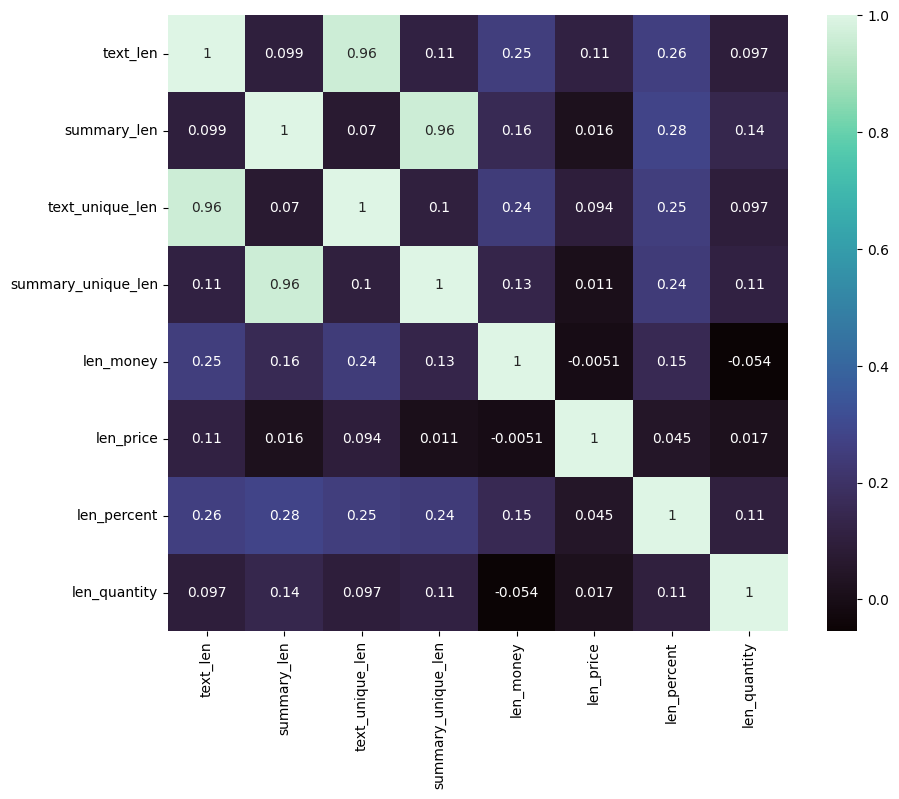

In [43]:
corr_m = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr_m, annot=True, cmap="mako")

Нет линейной зависимости между длиной саммари и численными показателями.

Посмотрим только те строки, в которых есть все данные

In [44]:
df_small = df.dropna()
df_small.shape

(400, 28)

<Axes: >

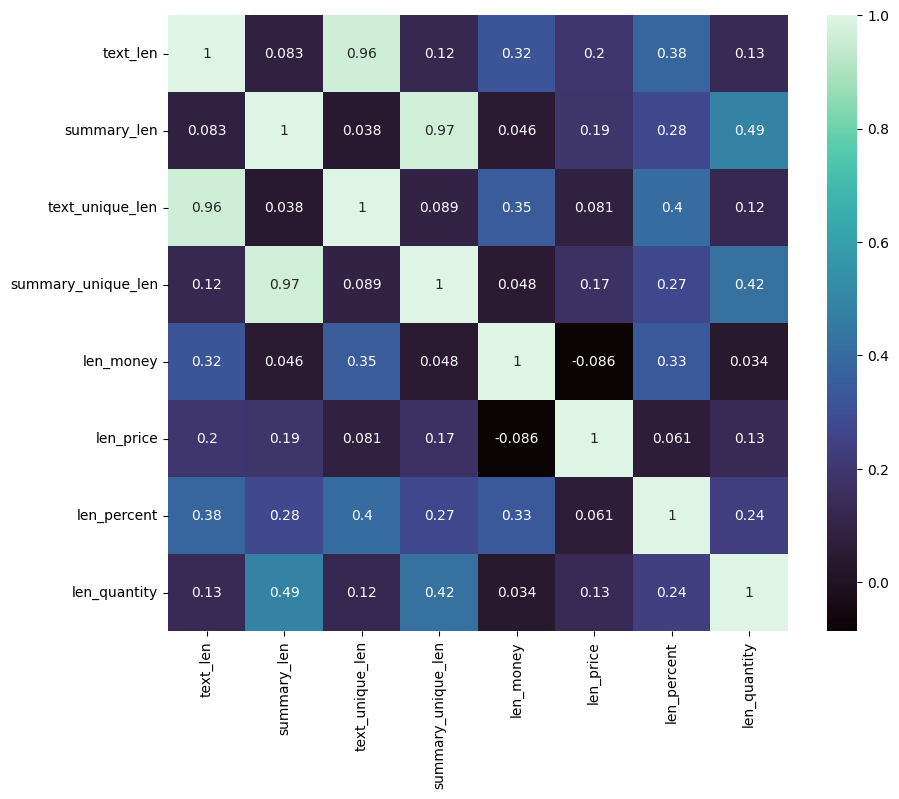

In [45]:
corr_m_small = df_small.select_dtypes(include=np.number).corr()
sns.heatmap(corr_m_small, annot=True, cmap="mako")

В этом срезе появляется слабая корреляция между длиной саммари и столбцом quantity

Посмотрим все строки, для которых определено значение quantity и длина списка не равна 0

In [46]:
df_quant = df.dropna(subset="raw_quantity")
df_quant.shape

(11899, 28)

In [47]:
df_quant = df_quant[df_quant["len_quantity"] != 0]
df_quant.shape

(9596, 28)

<Axes: >

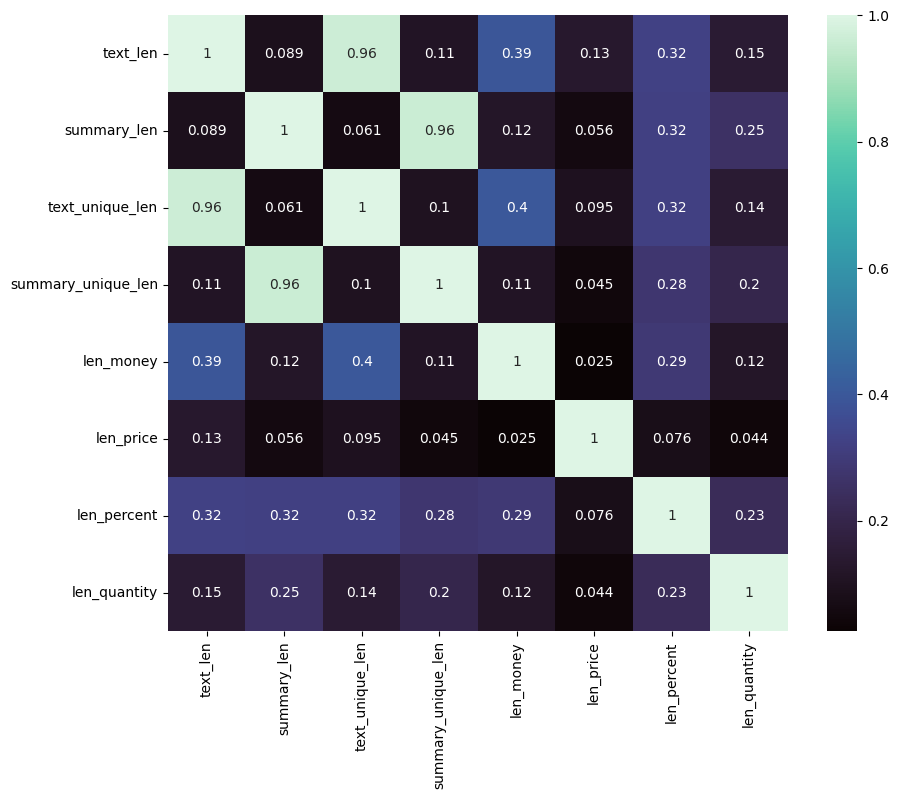

In [48]:
corr_quant = df_quant.select_dtypes(include=np.number).corr()
sns.heatmap(corr_quant, annot=True, cmap="mako")

Посмотрим графики распределения слов 

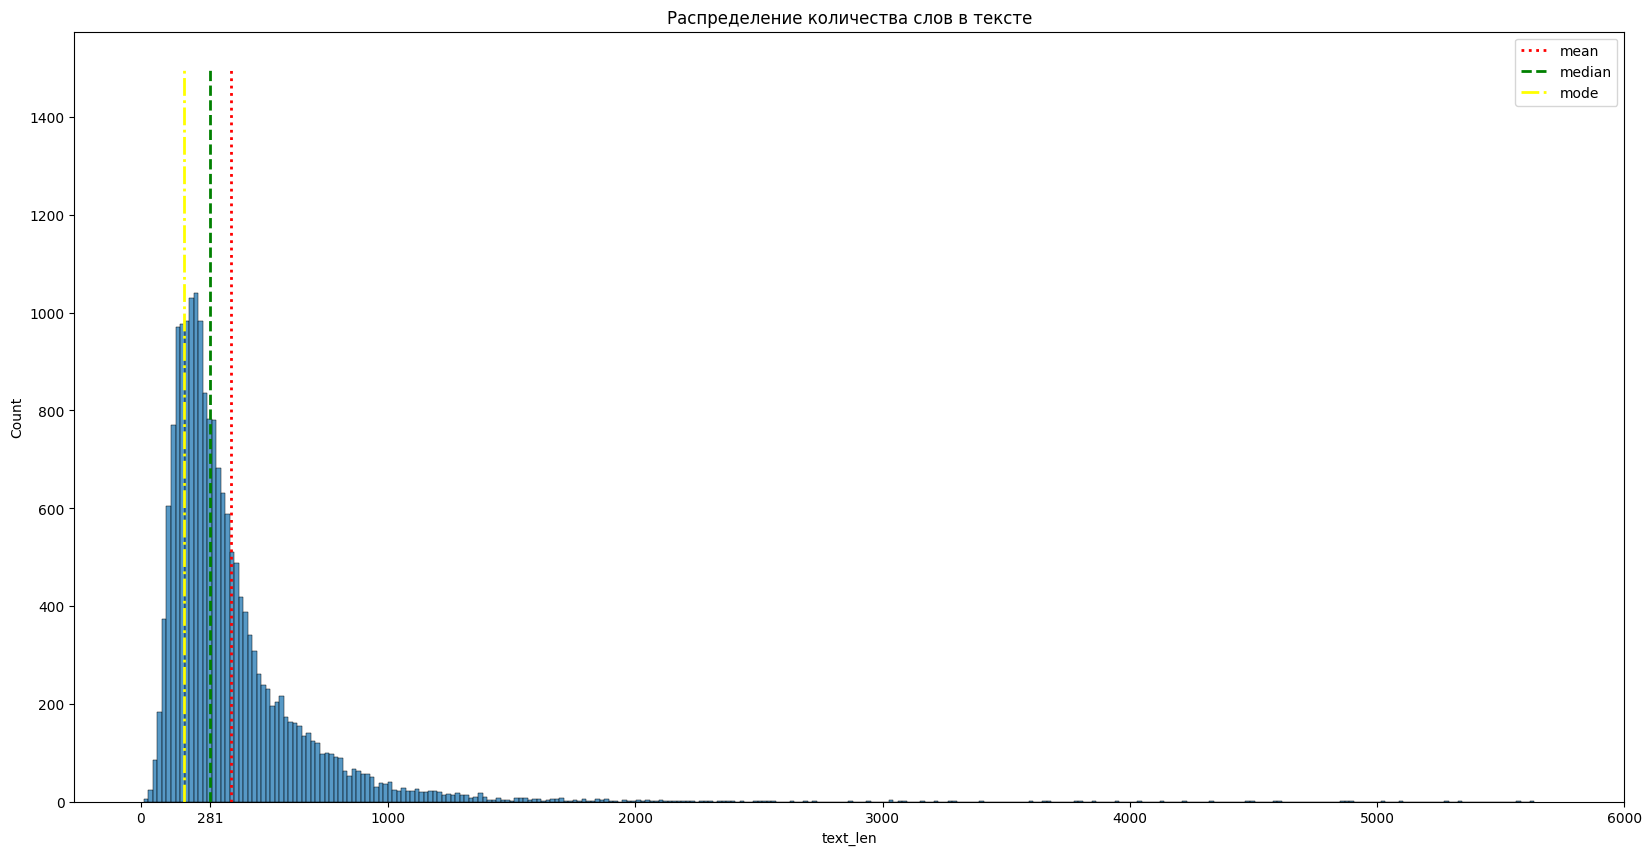

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.histplot(df, x="text_len")
plt.plot(
    [df.text_len.mean(), df.text_len.mean()],
    [0, 1500],
    label="mean",
    linestyle=":",
    linewidth=2,
    color="r",
)
plt.plot(
    [df.text_len.median(), df.text_len.median()],
    [0, 1500],
    label="median",
    linestyle="--",
    linewidth=2,
    color="g",
)
plt.plot(
    [df.text_len.mode()[0], df.text_len.mode()[0]],
    [0, 1500],
    label="mode",
    linestyle="-.",
    linewidth=2,
    color="yellow",
)
plt.title("Распределение количества слов в тексте")

xt = ax.get_xticks() 
xt=np.append(xt, np.round(df.text_len.median(), 1))
ax.set_xticks(xt[1:])
plt.legend()
plt.show()

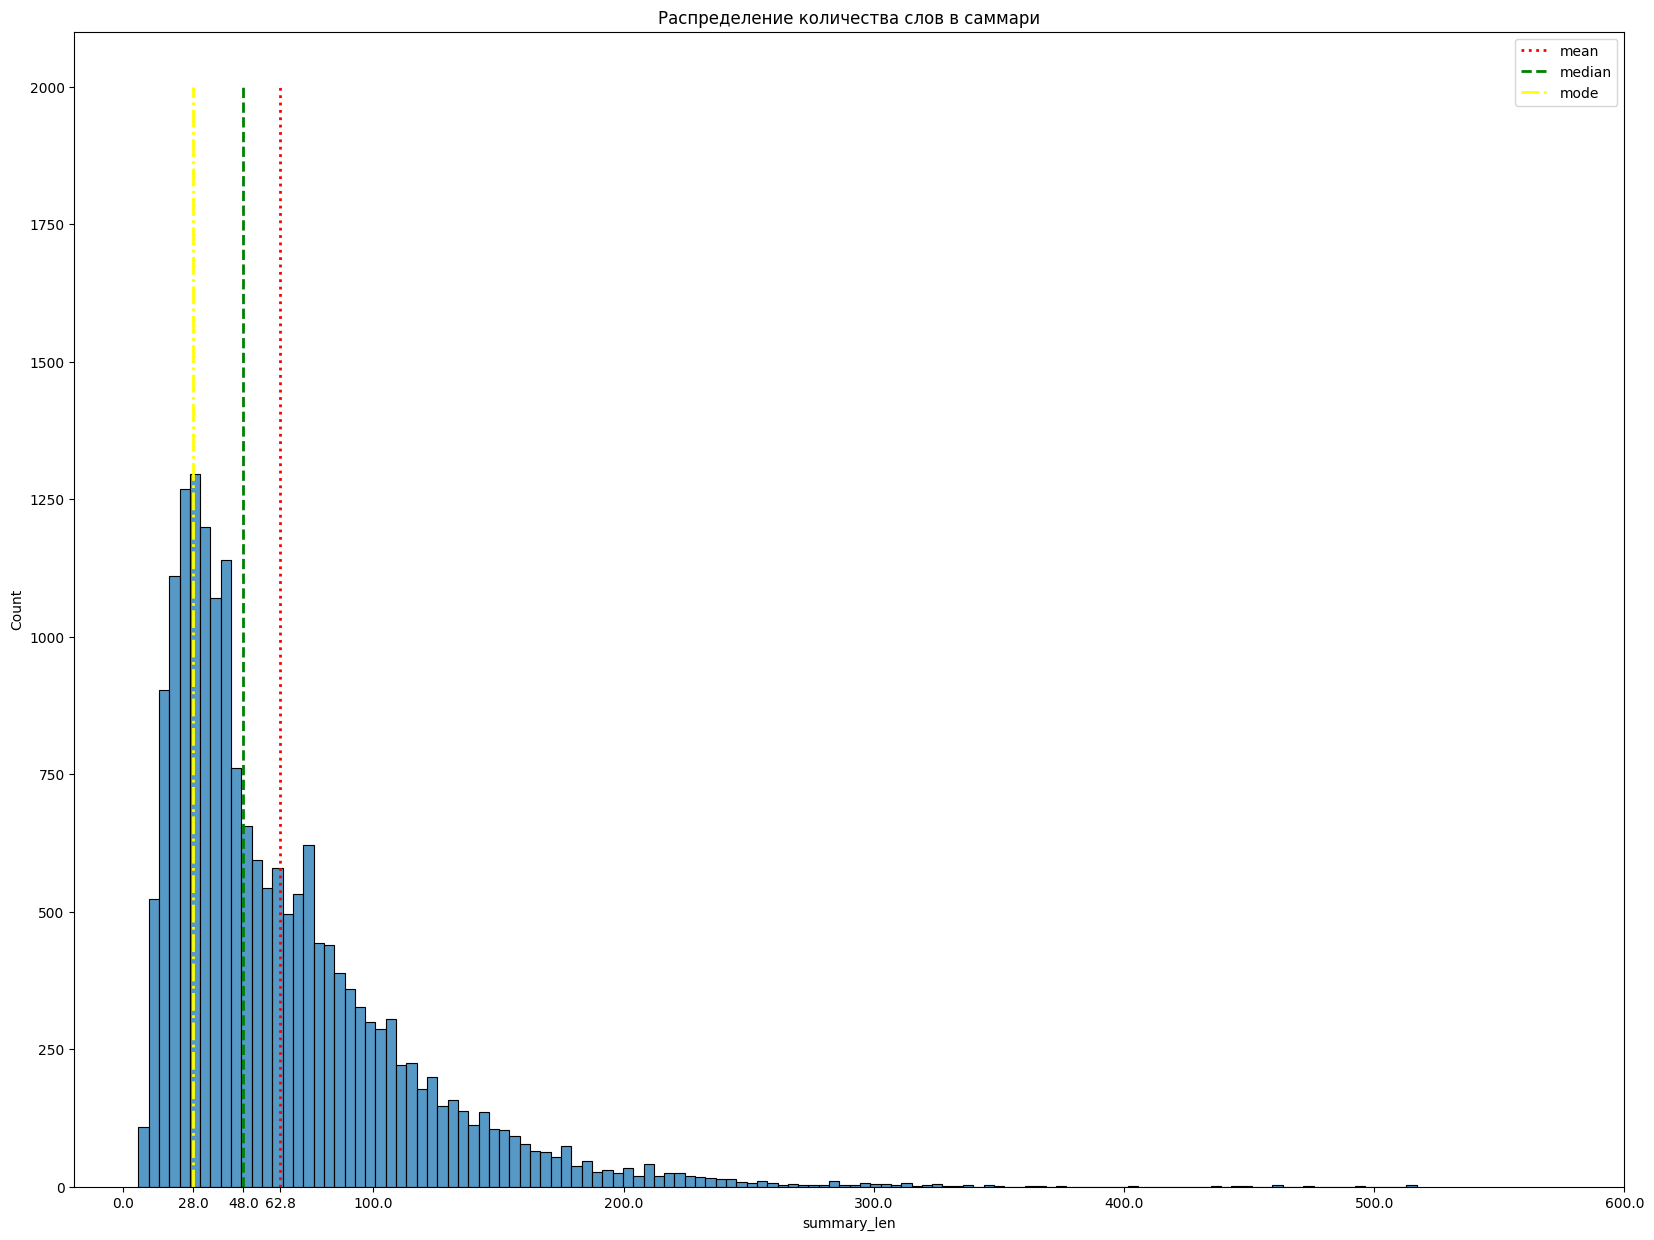

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
sns.histplot(df, x="summary_len")
plt.plot(
    [df.summary_len.mean(), df.summary_len.mean()],
    [0, 2000],
    label="mean",
    linestyle=":",
    linewidth=2,
    color="r",
)
plt.plot(
    [df.summary_len.median(), df.summary_len.median()],
    [0, 2000],
    label="median",
    linestyle="--",
    linewidth=2,
    color="g",
)
plt.plot(
    [df.summary_len.mode()[0], df.summary_len.mode()[0]],
    [0, 2000],
    label="mode",
    linestyle="-.",
    linewidth=2,
    color="yellow",
)
plt.title("Распределение количества слов в саммари")
xt = ax.get_xticks()
xt = np.append(
    xt,
    [
        df.summary_len.mode()[0],
        np.round(df.summary_len.median(), 1),
        np.round(df.summary_len.mean(), 1),
    ],
)
ax.set_xticks(xt[1:])
plt.legend()
plt.show()

Посмотрим на самые длинные саммари

In [51]:
df[df.summary_len > 300].shape

(43, 28)

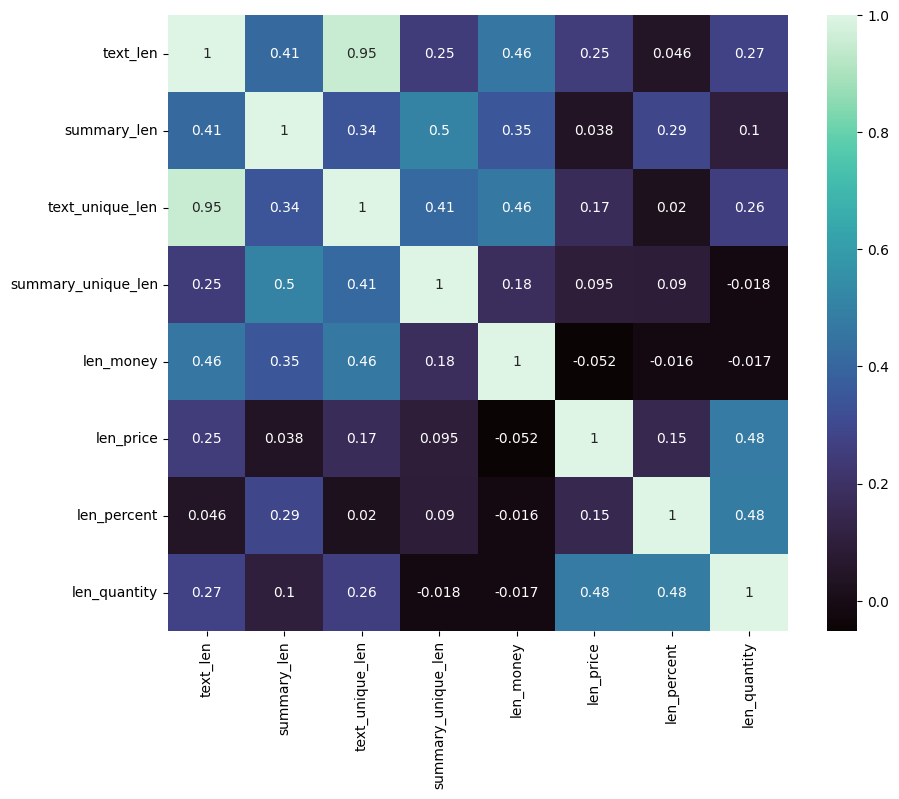

In [52]:
sns.heatmap(
    df[df.summary_len > 300].select_dtypes(include=np.number).corr(),
    annot=True,
    cmap="mako",
);

<Axes: >

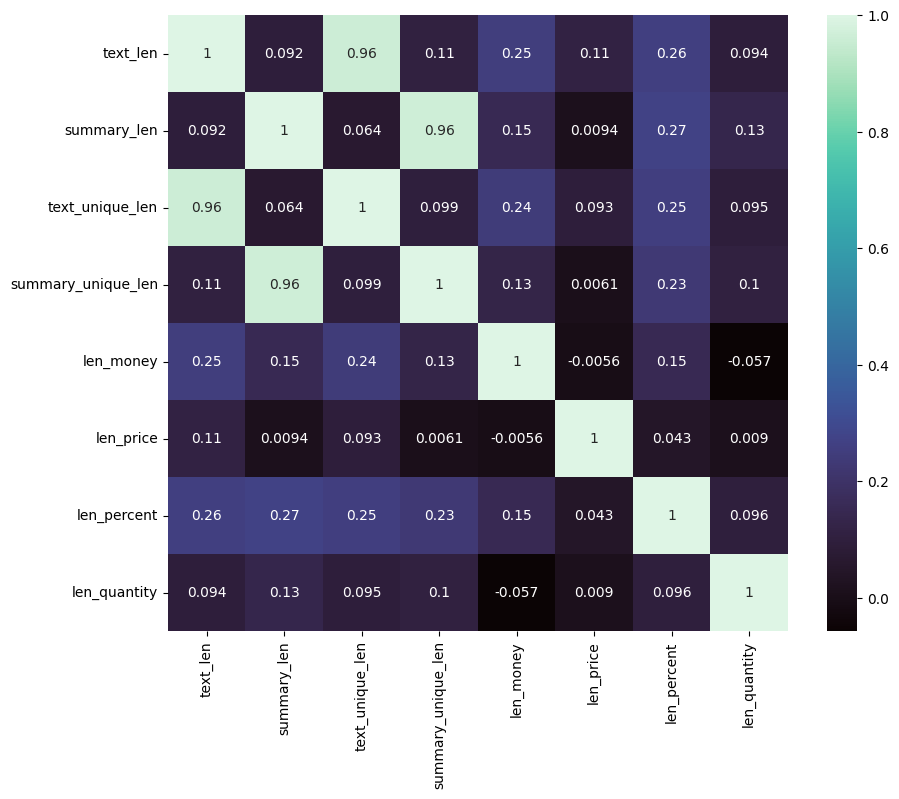

In [53]:
sns.heatmap(df[df.summary_len <= 300].select_dtypes(include=np.number).corr(), annot=True, cmap="mako")

In [54]:
df[df.summary_len > 450][["len_money", "len_price", "len_percent", "len_quantity"]]

,len_money,len_price,len_percent,len_quantity
1254,8,0,5,10
1754,10,0,2,0
2812,0,0,10,0
3593,7,0,9,0
6914,1,0,4,0
8161,6,0,13,0
10435,5,2,11,22


In [55]:
df[df.summary_len == df.summary_len.max()]

,text,title,title_en,url,published_parsed,raw_money,raw_price,raw_percent,raw_quantity,summary,...,summary_unique_len,money,price,percent,quantity,len_money,len_price,len_percent,len_quantity,news_date
2812,"Министерство промышленности, торговли и туризм...",Внешнеторговый оборот Испании за январь-июнь 2...,Spain's foreign trade turnover for January-Jun...,https://esp.minpromtorg.gov.ru/news/?alias=vne...,2022-08-25 03:00:00,"190,919 млрд евро, 222,882 млрд евро, 31,963 м...",NaN,"0,2%, 0,3%, 0,9%, + 1, 0 %, 10,4%, 10,7%, 10,9...",NaN,Внешнеторговый оборот Испании за январь-июнь 2...,...,194,{},{},"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}",{},0,0,10,0,2022


In [56]:
df[df.summary_len == df.summary_len.max()]['text'].values[0]

'Министерство промышленности, торговли и туризма Испании опубликовало данные о развитии внешнеторговых связей страны за январь-май 2022 года. Полная информация представлена по ссылке: Spain trade 6 meses. В соответствии с данными Министерства промышленности, торговли и туризма Испании, внешнеторговый оборот страны за январь-июнь 2022 года вырос на 32,9% исоставил 413,801 млрд евро. Испанский экспорт увеличился на 24,8% по сравнению с аналогичным периодом 2021 года и достиг 190,919 млрд евро, импорт - на 40,7% до 222,882 млрд евро. Физические объемы экспорта увеличились на 6,6%, импорта – на 17,7%. Опережающее наращивание импортных закупок из-за роста цен на энергоресурсы по сравнению с развитием экспорта в целом привело к увеличениюв 5,9 раз по сравнению с тем же периодом 2021 г. дефицита торгового баланса, который составил 31,963 млрд евро. Баланс неэнергетических товаров также показал отрицательное сальдо в размере 6,069 млрд евро в сравнении с профицитом в 4,7 млрд евро в том же пер

In [57]:
print(df[df.summary_len == df.summary_len.max()]["summary"].values[0])

Внешнеторговый оборот Испании за январь-июнь 2022 года вырос на 32,9% и составил 413,801 млрд евро. Испанский экспорт увеличился на 24,8% по сравнению с аналогичным периодом 2021 года и достиг 190,919 млрд евро, импорт - на 40,7% до 222,882 млрд евро. Физические объемы экспорта увеличились на 6,6%, импорта – на 17,7%. Структура испанского экспорта в отчетный период не претерпела изменений и была представлена химической продукцией (18,5% от общего объема, рост на 41,9%), продуктами питания, напитками и табаком (доля 17,1%, рост на 13,4%), машинами и оборудованием (доля 17,0%, рост на 10,7%), нехимическими полуфабрикатами (доля 11,9%, рост на 13,4%), продукцией автомобильной промышленности (доля 11,4%, рост на 0,2%) и др. Структура импорта была следующая: энергетические товары (19,7%), оборудование (19,1%), химическая продукция (17,5%), продукты питания, напитки, табачные изделия (10,9%) и др. За отчетный период высокими темпами рос импорт энергетических товаров (на 104,0%), полуфабрикат

In [58]:
df[df.summary_len == df.summary_len.max()][["len_money", "len_price", "len_percent", "len_quantity"]]

,len_money,len_price,len_percent,len_quantity
2812,0,0,10,0


Для самых длинных саммари определены только проценты и деньги. Для одной строки цена.

Посмотрим статистики, сгруппированные по сущностям

In [59]:
data = df.groupby("len_quantity").agg({"summary_len": ["min", "mean", "max", "count"]})
data

summary_len                       
                     min        mean  max count
len_quantity                                   
0                      6   63.068199  517  9311
1                      6   56.060923  346  4596
2                      9   60.557038  322  2174
3                      7   64.634146  345  1148
4                      9   70.909091  300   605
5                     12   71.206704  284   358
6                     10   83.695279  363   233
7                     14   78.798507  240   134
8                      8   93.981132  373   106
9                     12   93.142857  269    56
10                    16  125.183673  463    49
11                    28  100.259259  209    27
12                    14  107.461538  311    26
13                    22  103.076923  221    13
14                    15  144.000000  446    19
15                    16  124.125000  269     8
16                    52  101.300000  147    10
17                    24  154.000000  264     6
18                   100  139.200000  179     5
19                   167  219.000000  286     3
20                    39  162.500000  286     2
21                    33  102.000000  178     4
22                   208  319.000000  514     3
23                   105  150.500000  196     2
24                   181  233.000000  306     3
28                   228  228.000000  228     1
30                   140  140.000000  140     1
31                    58  147.000000  236     2
36                   127  127.000000  127     1
39                    61   61.000000   61     1

Новости, в которых до 10 показателей len_quantity

array([[<Axes: title={'center': 'summary_len'}>]], dtype=object)

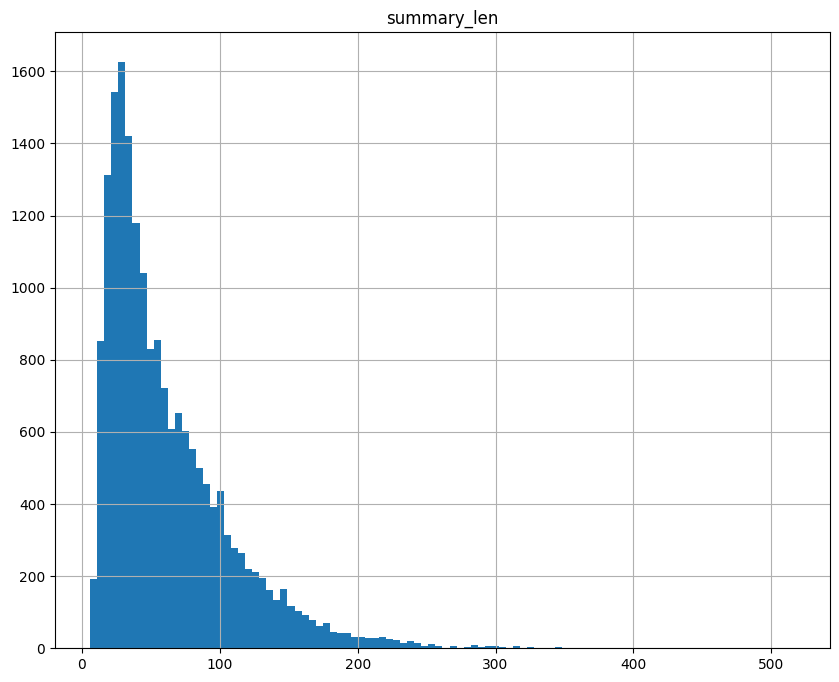

In [60]:
df[df.len_quantity < 10].hist(column="summary_len", sharex=True, grid=True, bins=100)

In [61]:
df[(df.len_quantity < 10) & ((df.summary_len > 300))].shape

(35, 28)

In [62]:
df[(df.len_quantity < 10) & ((df.summary_len > 300))][
    ["len_money", "len_price", "len_percent", "len_quantity"]
]

,len_money,len_price,len_percent,len_quantity
14997,0,0,2,0
1395,4,0,4,0
1754,10,0,2,0
2428,3,0,0,0
2506,2,0,2,0
2547,4,0,9,6
2598,4,0,7,3
2812,0,0,10,0
2779,0,0,3,0
3077,0,0,1,0


Надо посмотреть совпадения, сколько сущностей из списков попали в саммари.

Посмотрим, сколько продуктов попадает в саммари

In [63]:
def get_matches(df, features):
    for feature in features:
        matches = []
        for i, row in df.iterrows():
            match = 0
            for num in row[feature]:
                if str(num) in row["summary"]:
                    match += 1
            matches.append(match)
        df[f'match_{feature}'] = matches
    return df

In [64]:
nums = ["money", "price", "percent", "quantity"]

In [65]:
df = get_matches(df, nums)

Смотрим матчи только в тех новостях, для которых определены сущности

In [72]:
data_money = (
    df[~(df["raw_money"].isna())]
    .groupby("match_money")
    .agg(
        {
            "summary_len": ["min", "mean", "max", "count"],
            "len_money": ["min", "mean", "max", "count"],
            "text_len": ["min", "mean", "max", "count"],
        }
    )
)
data_money

summary_len                        len_money                       \
                    min        mean  max count       min       mean max count   
match_money                                                                     
0                     6   51.688330  517  5047         0   1.307906  19  5047   
1                     8   63.002299  460  3480         1   1.721839  21  3480   
2                    11   78.537994  514  1316         2   2.994681  26  1316   
3                    16   94.760314  349   509         3   4.432220  27   509   
4                    20  112.700375  404   267         4   5.243446  23   267   
5                    30  116.651899  365   158         5   6.670886  26   158   
6                    42  135.466019  451   103         6   7.660194  18   103   
7                    37  148.362319  496    69         7   9.275362  30    69   
8                    62  149.705882  463    34         8  10.323529  24    34   
9                    78  151.875000  220    16         9  11.750000  32    16   
10                   83  173.000000  473    20        10  13.950000  30    20   
11                  119  190.666667  271     9        11  15.888889  29     9   
12                  162  229.000000  264     4        12  14.250000  21     4   
13                  157  190.600000  224     5        13  14.200000  16     5   
14                  144  233.333333  446     6        14  14.166667  15     6   
15                  246  248.000000  250     2        15  16.500000  18     2   
16                  346  346.000000  346     1        16  16.000000  16     1   
18                  227  227.000000  227     1        19  19.000000  19     1   

            text_len                          
                 min        mean   max count  
match_money                                   
0                 14  437.498712  5564  5047  
1                 12  344.356322  5636  3480  
2                 40  362.724924  4853  1316  
3                 87  443.563851  5337   509  
4                 91  378.003745  5282   267  
5                102  394.278481  3654   158  
6                111  383.747573  1511   103  
7                108  603.855072  4037    69  
8                111  592.117647  5102    34  
9                183  472.000000  1801    16  
10               109  544.600000  1670    20  
11               156  827.222222  2389     9  
12               258  465.250000   879     4  
13               424  568.600000   751     5  
14               220  617.166667  2101     6  
15               325  507.500000   690     2  
16               713  713.000000   713     1  
18               266  266.000000   266     1

In [67]:
df[df['match_money']==18]['summary'].values

array(['Россия в ноябре 2023 года сократила объем вложений в американские государственные облигации до $28 млн.\nПоказатель российских вложений в американские госбумаги в 2023 году уменьшился на $3 млн по сравнению с октябрьским значением в $31 млн и более чем в 2,5 раза по сравнению с сентябрем 2023 года, когда объем вложений РФ в гособлигации США составил $73 млн. В августе 2023 года этот показатель составил $31 млн, в июле - $29 млн, в июне - $33 млн, в мае - $36 млн, в апреле - $35 млн, в марте - $77 млн, в феврале - $75 млн.\nРоссия начала резко сокращать вложения в американский госдолг весной 2018 года: в апреле их уровень снизился с $96 млрд до $48,7 млрд, в мае - до $14,9 млрд. В ноябре 2023 года крупнейшим держателем американских государственных бумаг осталась Япония, вложившая в гособлигации США $1,127 трлн по сравнению с $1,09 трлн в октябре. Второе место удерживает Китай с $782 млрд по сравнению с $769,6 млрд в октябре 2023 года. Пекин постепенно сокращает свои вложения в а

In [73]:
data_price = (
    df[~(df["raw_price"].isna())]
    .groupby("match_price")
    .agg(
        {
            "summary_len": ["min", "mean", "max", "count"],
            "len_price": ["min", "mean", "max", "count"],
            "text_len": ["min", "mean", "max", "count"],
        }
    )
)
data_price

summary_len                        len_price                      \
                    min        mean  max count       min      mean max count   
match_price                                                                    
0                    11   58.870602  338   881         0  0.631101   5   881   
1                    10   83.492647  514   136         1  1.169118  12   136   
2                    43  103.181818  195    11         2  2.454545   6    11   
3                   239  239.000000  239     1         3  3.000000   3     1   
4                    68   78.000000   88     2         4  4.000000   4     2   
5                   117  117.000000  117     1         5  5.000000   5     1   
6                   203  203.500000  204     2         6  6.000000   6     2   

            text_len                          
                 min        mean   max count  
match_price                                   
0                 65  553.937571  4037   881  
1                 42  490.514706  5023   136  
2                117  453.454545  1670    11  
3                644  644.000000   644     1  
4                200  205.000000   210     2  
5                243  243.000000   243     1  
6                235  243.500000   252     2

In [74]:
data_percent = (
    df[~(df["raw_percent"].isna())]
    .groupby("match_percent")
    .agg(
        {
            "summary_len": ["min", "mean", "max", "count"],
            "len_percent": ["min", "mean", "max", "count"],
            "text_len": ["min", "mean", "max", "count"],
        }
    )
)
data_percent

summary_len                        len_percent                 \
                      min        mean  max count         min       mean max   
match_percent                                                                 
0                       6   54.440723  339  5584           0   1.337213  18   
1                      10   77.516356  446  2843           1   1.718255  15   
2                      10   92.446396  473  1082           2   2.996303  23   
3                      14  111.092369  338   498           3   3.957831  16   
4                      18  126.277344  460   256           4   5.328125  26   
5                      28  137.364286  463   140           5   6.664286  34   
6                      58  149.564706  373    85           6   7.517647  33   
7                      85  156.189655  308    58           7   8.327586  32   
8                      73  164.160000  267    25           8   9.760000  16   
9                      54  214.821429  496    28           9  10.500000  32   
10                    109  192.461538  517    13          10  11.846154  18   
11                    138  206.000000  514    14          11  12.785714  19   
12                    120  227.636364  327    11          12  12.090909  13   
13                    174  277.333333  451     6          13  15.166667  22   
14                    161  187.000000  219     3          14  14.666667  16   
15                    192  242.500000  293     2          15  15.000000  15   
16                    214  214.000000  214     1          17  17.000000  17   
17                    239  239.000000  239     1          17  17.000000  17   

                    text_len                          
              count      min        mean   max count  
match_percent                                         
0              5584       34  443.232271  5636  5584  
1              2843       14  347.670067  4905  2843  
2              1082       35  369.751386  5564  1082  
3               498       38  357.291165  2045   498  
4               256       72  366.675781  5282   256  
5               140       92  445.078571  5337   140  
6                85       78  417.082353  5328    85  
7                58      116  432.189655  5102    58  
8                25      130  470.560000  1560    25  
9                28      136  641.250000  4037    28  
10               13      165  368.307692   743    13  
11               14      190  501.857143  2389    14  
12               11      195  353.818182   690    11  
13                6      336  550.000000  1005     6  
14                3      225  347.000000   446     3  
15                2      229  292.000000   355     2  
16                1      226  226.000000   226     1  
17                1      274  274.000000   274     1

In [75]:
data_quantity = (
    df[~(df["raw_quantity"].isna())]
    .groupby("match_quantity")
    .agg(
        {
            "summary_len": ["min", "mean", "max", "count"],
            "len_quantity": ["min", "mean", "max", "count"],
            "text_len": ["min", "mean", "max", "count"],
        }
    )
)
data_quantity

summary_len                        len_quantity                 \
                       min        mean  max count          min       mean max   
match_quantity                                                                  
0                        6   51.899294  348  7219            0   1.236044  31   
1                        8   66.632931  346  2648            1   1.755665  16   
2                       12   84.151923  322  1040            2   3.043269  18   
3                       19   98.009592  363   417            3   4.117506  16   
4                       21  113.365741  300   216            4   5.212963  21   
5                       42  119.185841  263   113            5   6.433628  39   
6                       44  140.692308  316    78            6   7.500000  23   
7                       28  137.425532  240    47            7   8.510638  16   
8                       57  144.542857  373    35            8  10.028571  36   
9                       54  173.588235  446    17            9  10.470588  18   
10                      97  201.333333  463    21           10  11.523810  24   
11                      91  182.266667  307    15           11  13.066667  17   
12                      66  176.363636  286    11           12  15.181818  24   
13                     112  171.857143  221     7           13  17.000000  30   
14                      76  132.500000  182     4           14  15.000000  17   
15                     114  182.666667  286     3           16  18.666667  21   
16                     208  224.000000  236     3           22  27.000000  31   
17                     167  167.000000  167     1           19  19.000000  19   
22                     235  374.500000  514     2           22  22.000000  22   
23                     196  196.000000  196     1           23  23.000000  23   
24                     306  306.000000  306     1           24  24.000000  24   

                     text_len                          
               count      min        mean   max count  
match_quantity                                         
0               7219       49  432.233135  5636  7219  
1               2648       20  321.214879  3281  2648  
2               1040       35  311.041346  5564  1040  
3                417       51  287.872902  1537   417  
4                216       59  303.166667  5337   216  
5                113       66  316.424779  5280   113  
6                 78       66  368.448718  4853    78  
7                 47      108  286.765957  1708    47  
8                 35       88  479.828571  5102    35  
9                 17      107  392.117647  2101    17  
10                21      138  348.571429   778    21  
11                15      144  402.266667   883    15  
12                11      151  405.363636   855    11  
13                 7      198  341.428571   764     7  
14                 4      171  274.000000   361     4  
15                 3      191  405.333333   580     3  
16                 3      418  672.000000   837     3  
17                 1      517  517.000000   517     1  
22                 2      241  609.000000   977     2  
23                 1      224  224.000000   224     1  
24                 1      507  507.000000   507     1

В саммари попадает бОльшая часть числовых данных. При этом точно выявить зависимость не удалось, насколько зависит количество матчей от длины текста, или насколько зависит длина саммари от матчей.

In [2]:
# df.to_excel('./data/numbers_with_match.xlsx', index = False)